# MP 1 : Classification, wieght sharing, auxiliary losses

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random 

from dlc_pratical_prologue import generate_pair_sets

## The data

Train set size = Test size = 1000

In [3]:
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(N)

In [4]:
inp = train_input[0]

In [5]:
train_input.shape, train_target.shape, train_classes.shape

(torch.Size([1000, 2, 14, 14]), torch.Size([1000]), torch.Size([1000, 2]))

In [6]:
test_input.shape, test_target.shape, test_classes.shape

(torch.Size([1000, 2, 14, 14]), torch.Size([1000]), torch.Size([1000, 2]))

#### The images

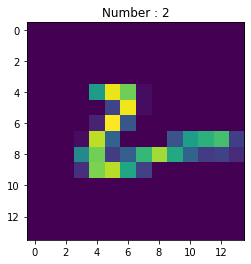

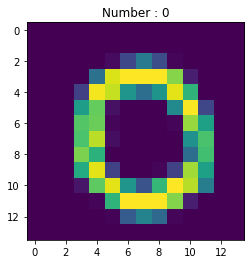

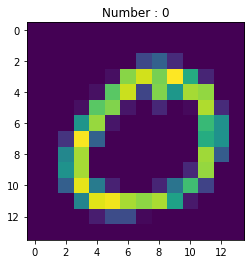

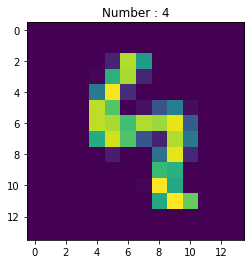

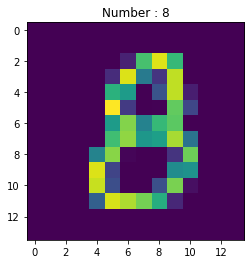

<Figure size 432x288 with 0 Axes>

In [7]:
for i in range(5):
    index = random.randint(0, 1000)
    plt.imshow(train_input[index][0])
    plt.title("Number : {0}".format(train_classes[index][0]))
    plt.figure()

#### Class balance

In [8]:
#Train
num_ones = train_target.sum()
num_zeros = N - num_ones
num_zeros, num_ones

(tensor(449), tensor(551))

In [9]:
#Test
num_ones = test_target.sum()
num_zeros = N - num_ones
num_zeros, num_ones

(tensor(474), tensor(526))

(array([173., 252., 204., 234., 184., 185., 191., 199., 182., 196.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

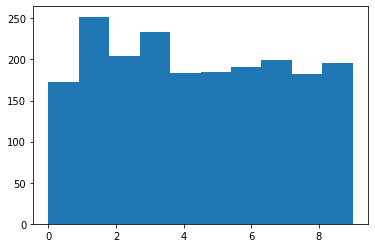

In [10]:
plt.hist(train_classes.reshape(2000))

(array([197., 232., 192., 192., 178., 197., 192., 217., 210., 193.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

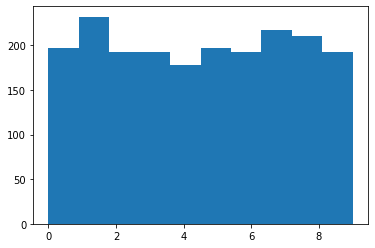

In [11]:
plt.hist(test_classes.reshape(2000))

Balance classes ? 

## The model
### Shape

- Input (2x14x14):2 14x14 greyscale images
- Output (1x1): one class (0 or 1)
- Layers?

#### Model structure
- LeNet5: https://www.datasciencecentral.com/profiles/blogs/lenet-5-a-classic-cnn-architecture#:~:text=The%20LeNet%2D5%20architecture%20consists,and%20finally%20a%20softmax%20classifier.
- Multi.column DNN: https://arxiv.org/pdf/1202.2745.pdf

### Building the model

In [179]:
def plot_train_vs_test(train_acc, test_acc, train_loss, test_loss):
    best_ind = test_acc.index(max(test_acc)) + 1
    plt.plot(list(range(1, len(train_acc) + 1)), train_acc, color="blue", label="train")
    plt.plot(list(range(1, len(test_acc) + 1)), test_acc, color="red", label="test")
    plt.vlines(best_ind, 0, 1, label="best epoch = {0}".format(best_ind))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy given epoch for train dataset (blue) and test dataset (red)")
    plt.legend()
    plt.figure()
    ######
    plt.plot(list(range(1, len(train_loss) + 1)), train_loss, color="blue", label="train")
    plt.plot(list(range(1, len(test_loss) + 1)), test_loss, color="red", label="test")
    plt.vlines(best_ind, 0, max(test_loss), label="best epoch = {0}".format(best_ind))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss given epoch for train dataset (blue) and test dataset (red)")
    plt.legend()
    plt.figure()

In [213]:
N_EPOCH = 50
BATCH = 100
LR = 0.01
class Sub_LeNet5(nn.Module):
    
    def __init__(self, weight_sharing=False, aux_loss=False):
        super(Sub_LeNet5, self).__init__()
        #settings stuff
        self.weight_sharing = weight_sharing
        self.aux_loss = aux_loss 
        
        #Layers from LeNet5 (but start from layer 3, to adapt to the size of the images)
        #For the first image
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.avgPool = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(16, 120, kernel_size=5, stride=1)        
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)
        
        #For the second image (only use if no weight sharing)
        if not weight_sharing:
            self.conv1_im2 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
            self.avgPool_im2 = nn.AvgPool2d(2, stride=2)
            self.conv2_im2 = nn.Conv2d(16, 120, kernel_size=5)
            self.linear1_im2 = nn.Linear(120, 84)
            self.linear2_im2 = nn.Linear(84, 10)
        
        #To compare the images
        if not aux_loss:
            self.comp1 = nn.Linear(20, 100)
            self.comp2 = nn.Linear(100, 100)
            self.out = nn.Linear(100, 1)
        
    def forward(self, x):
        im1, im2 =  x[:, 0], x[:, 1]
        
        im1 = im1.reshape(-1,1,14,14)
        im1 = torch.tanh(self.conv1(im1)) 
        im1 = self.avgPool(im1)
        im1 = torch.tanh(self.conv2(im1)).reshape(-1, 120)
        im1 = torch.relu(self.linear1(im1))
        im1 = torch.softmax(self.linear2(im1), dim=1)
        
        im2 = im2.reshape(-1,1,14,14)
        if self.weight_sharing:        
            #Use the same layers for im1 and im2 if there is weight sharing
            im2 = torch.tanh(self.conv1(im2)) 
            im2 = self.avgPool(im2)
            im2 = torch.tanh(self.conv2(im2)).reshape(-1, 120)
            im2 = torch.relu(self.linear1(im2))
            im2 = torch.softmax(self.linear2(im2), dim=1)
        else : 
            im2 = torch.tanh(self.conv1_im2(im2))
            im2 = self.avgPool_im2(im2)
            im2 = torch.tanh(self.conv2_im2(im2)).reshape(-1, 120)
            im2 = torch.relu(self.linear1_im2(im2))
            im2 = torch.softmax(self.linear2_im2(im2), dim=1)
        
        if self.aux_loss:
            return im1, im2
        else:
            preds = torch.cat((im1, im2), dim=1)
            preds = torch.relu(self.comp1(preds))
            preds = torch.relu(self.comp2(preds))
            y = torch.sigmoid(self.out(preds)).reshape(-1)
            return y
    
    def predict(self, test, target, loss_function):
        with torch.no_grad():
            if self.aux_loss:
                classes1, classes2 = self(test)
                loss = loss_function(classes1, target[:, 0]) + loss_function(classes2, target[:, 1])                    
                nums1, nums2 =  classes1.max(dim=1)[1], classes2.max(dim=1)[1]
                pred = (nums1 <= nums2)
                target = target[:,0] <= target[:,1]
                correct = (pred == target).sum().item()
                acc = correct / test.size(0)
                return pred, acc, loss
            else:
                target = target.float()
                output = self(test)
                loss = loss_function(output, target)
                pred = output.round()
                correct = (target == pred).sum().item()
                acc = correct / test.size(0)
                return pred, acc, loss
            
    def fit(self, train_input, train_target, train_classes, test_input, test_target, test_classes, optimizer, loss_function, lr=LR, batch_size=BATCH, N_EPOCH=N_EPOCH):
        model_name = "best_model"
        if self.weight_sharing:
            model_name += "_with_ws"
        if self.aux_loss:
            model_name += "_with_aux_loss"
        
        if self.aux_loss:
            dataset = torch.utils.data.TensorDataset(train_input, train_classes)
            loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        else:
            dataset = torch.utils.data.TensorDataset(train_input, train_target.float())
            loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        train_accs, train_losses = [], []
        test_accs, test_losses = [], []
        max_acc, best_epoch = -1, -1
        for epoch in range(N_EPOCH):
            running_loss = 0
            for data in loader:
                batch_x, batch_y = data
                loss = 0
                if self.aux_loss:
                    classes1, classes2 = self(batch_x)
                    loss = loss_function(classes1, batch_y[:, 0]) + loss_function(classes2, batch_y[:, 1])                    
                else:
                    outputs = self(batch_x)
                    loss = loss_function(outputs, batch_y)
                    
                running_loss += loss.item()
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                _, train_acc, train_loss = self.predict(train_input, train_classes if self.aux_loss else train_target, criterion) 
                _, test_acc, test_loss = self.predict(test_input, test_classes if self.aux_loss else test_target, criterion)
            
            if test_acc > max_acc:
                max_acc = test_acc
                best_epoch = epoch + 1
                torch.save(self.state_dict(), model_name + ".p")
            train_accs.append(train_acc)
            train_losses.append(train_loss)
            test_accs.append(test_acc)
            test_losses.append(test_loss)
            print("Epoch {0} \t Loss: {1} \t Train accuracy: {2} \t Test accuracy: {3}".format(epoch + 1, running_loss, train_acc, test_acc))
            running_loss = 0.0
        plot_train_vs_test(train_accs, test_accs, train_losses, test_losses)
        return train_accs, train_losses, test_accs, test_losses 

### 1. No weight sharing, no auxiliary loss

Convert each images separately to a 10 dimensional tensors, using LeNet5 architecture, then use the two 10 dimensional tensors to interpret them in a few fully connected layers, and output the final class.

Number of params :  131401
Epoch 1 	 Loss: 6.847540616989136 	 Train accuracy: 0.687 	 Test accuracy: 0.664
Epoch 2 	 Loss: 5.902250587940216 	 Train accuracy: 0.757 	 Test accuracy: 0.732
Epoch 3 	 Loss: 5.054232180118561 	 Train accuracy: 0.678 	 Test accuracy: 0.66
Epoch 4 	 Loss: 4.5840446054935455 	 Train accuracy: 0.825 	 Test accuracy: 0.772
Epoch 5 	 Loss: 4.281681299209595 	 Train accuracy: 0.681 	 Test accuracy: 0.653
Epoch 6 	 Loss: 4.5158655643463135 	 Train accuracy: 0.814 	 Test accuracy: 0.758
Epoch 7 	 Loss: 3.598891258239746 	 Train accuracy: 0.864 	 Test accuracy: 0.81
Epoch 8 	 Loss: 3.3515313267707825 	 Train accuracy: 0.872 	 Test accuracy: 0.78
Epoch 9 	 Loss: 3.4166321754455566 	 Train accuracy: 0.893 	 Test accuracy: 0.797
Epoch 10 	 Loss: 3.2065642178058624 	 Train accuracy: 0.896 	 Test accuracy: 0.787
Epoch 11 	 Loss: 2.934705078601837 	 Train accuracy: 0.882 	 Test accuracy: 0.77
Epoch 12 	 Loss: 3.0863897502422333 	 Train accuracy: 0.882 	 Test accuracy: 0.

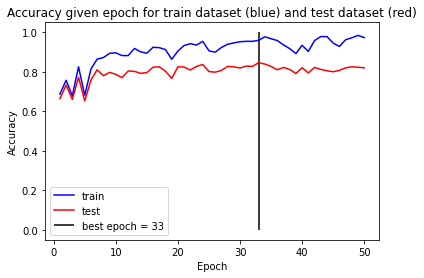

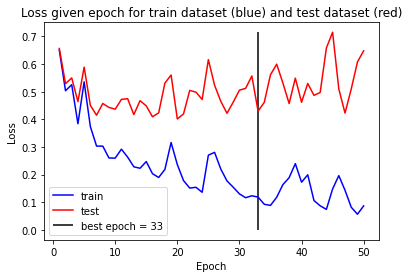

<Figure size 432x288 with 0 Axes>

In [193]:
model = Sub_LeNet5()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_params = sum(p.numel() for p in model.parameters())
print("Number of params : ", num_params)

train_acc, train_loss, test_acc, test_loss = model.fit(train_input, train_target, train_classes, test_input, test_target, test_classes, optimizer, criterion)        

### 2. Using weight sharing

Number of params :  71851
Epoch 1 	 Loss: 6.535108268260956 	 Train accuracy: 0.733 	 Test accuracy: 0.737
Epoch 2 	 Loss: 5.914198875427246 	 Train accuracy: 0.724 	 Test accuracy: 0.716
Epoch 3 	 Loss: 5.188916236162186 	 Train accuracy: 0.761 	 Test accuracy: 0.745
Epoch 4 	 Loss: 4.891962230205536 	 Train accuracy: 0.799 	 Test accuracy: 0.776
Epoch 5 	 Loss: 4.1128924787044525 	 Train accuracy: 0.834 	 Test accuracy: 0.8
Epoch 6 	 Loss: 3.7173668444156647 	 Train accuracy: 0.853 	 Test accuracy: 0.822
Epoch 7 	 Loss: 3.3464659452438354 	 Train accuracy: 0.884 	 Test accuracy: 0.843
Epoch 8 	 Loss: 3.0679985731840134 	 Train accuracy: 0.89 	 Test accuracy: 0.85
Epoch 9 	 Loss: 2.4956304281949997 	 Train accuracy: 0.918 	 Test accuracy: 0.848
Epoch 10 	 Loss: 2.793125092983246 	 Train accuracy: 0.881 	 Test accuracy: 0.833
Epoch 11 	 Loss: 3.007304757833481 	 Train accuracy: 0.917 	 Test accuracy: 0.85
Epoch 12 	 Loss: 2.467983305454254 	 Train accuracy: 0.907 	 Test accuracy: 0.835

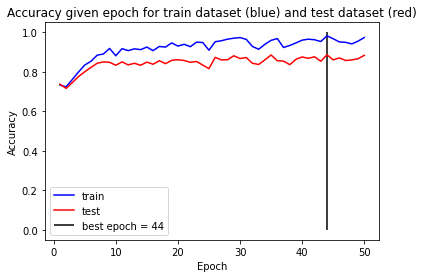

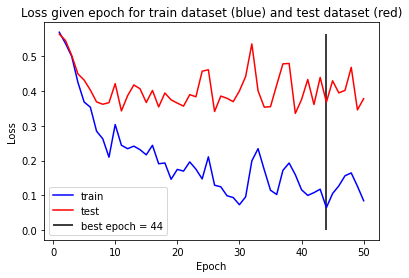

<Figure size 432x288 with 0 Axes>

In [194]:
model = Sub_LeNet5(weight_sharing=True)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_params = sum(p.numel() for p in model.parameters())
print("Number of params : ", num_params)

train_acc, train_loss, test_acc, test_loss = model.fit(train_input, train_target, train_classes, test_input, test_target, test_classes, optimizer, criterion)        

### 3. Using auxiliary loss

Number of params :  119100
Epoch 1 	 Loss: 40.751641035079956 	 Train accuracy: 0.789 	 Test accuracy: 0.769
Epoch 2 	 Loss: 35.35088038444519 	 Train accuracy: 0.815 	 Test accuracy: 0.792
Epoch 3 	 Loss: 34.474916219711304 	 Train accuracy: 0.838 	 Test accuracy: 0.802
Epoch 4 	 Loss: 33.79008412361145 	 Train accuracy: 0.839 	 Test accuracy: 0.811
Epoch 5 	 Loss: 33.79512143135071 	 Train accuracy: 0.85 	 Test accuracy: 0.827
Epoch 6 	 Loss: 33.49927353858948 	 Train accuracy: 0.857 	 Test accuracy: 0.833
Epoch 7 	 Loss: 33.55744671821594 	 Train accuracy: 0.868 	 Test accuracy: 0.856
Epoch 8 	 Loss: 33.486549854278564 	 Train accuracy: 0.836 	 Test accuracy: 0.811
Epoch 9 	 Loss: 33.40663814544678 	 Train accuracy: 0.87 	 Test accuracy: 0.844
Epoch 10 	 Loss: 33.0236759185791 	 Train accuracy: 0.854 	 Test accuracy: 0.844
Epoch 11 	 Loss: 33.03845977783203 	 Train accuracy: 0.86 	 Test accuracy: 0.838
Epoch 12 	 Loss: 32.91067171096802 	 Train accuracy: 0.871 	 Test accuracy: 0.848

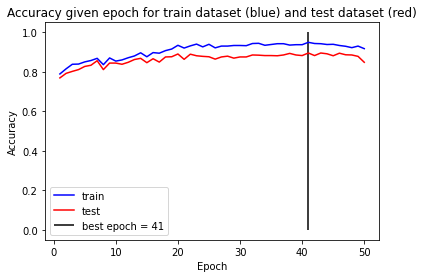

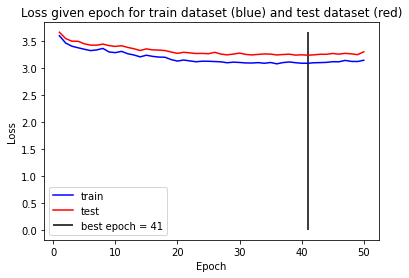

<Figure size 432x288 with 0 Axes>

In [215]:
model = Sub_LeNet5(aux_loss=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_params = sum(p.numel() for p in model.parameters())
print("Number of params : ", num_params)

train_acc, train_loss, test_acc, test_loss = model.fit(train_input, train_target, train_classes, test_input, test_target, test_classes, optimizer, criterion)        

### 4. Bad ass model: using it all

Number of params :  59550
Epoch 1 	 Loss: 39.80197739601135 	 Train accuracy: 0.85 	 Test accuracy: 0.85
Epoch 2 	 Loss: 33.13159108161926 	 Train accuracy: 0.888 	 Test accuracy: 0.874
Epoch 3 	 Loss: 32.815672159194946 	 Train accuracy: 0.898 	 Test accuracy: 0.874
Epoch 4 	 Loss: 32.63772439956665 	 Train accuracy: 0.899 	 Test accuracy: 0.879
Epoch 5 	 Loss: 32.366796016693115 	 Train accuracy: 0.905 	 Test accuracy: 0.883
Epoch 6 	 Loss: 32.1399359703064 	 Train accuracy: 0.919 	 Test accuracy: 0.9
Epoch 7 	 Loss: 32.088702917099 	 Train accuracy: 0.905 	 Test accuracy: 0.88
Epoch 8 	 Loss: 32.04638481140137 	 Train accuracy: 0.898 	 Test accuracy: 0.881
Epoch 9 	 Loss: 32.382715702056885 	 Train accuracy: 0.875 	 Test accuracy: 0.863
Epoch 10 	 Loss: 32.272048473358154 	 Train accuracy: 0.877 	 Test accuracy: 0.869
Epoch 11 	 Loss: 32.238260984420776 	 Train accuracy: 0.898 	 Test accuracy: 0.891
Epoch 12 	 Loss: 32.21949577331543 	 Train accuracy: 0.897 	 Test accuracy: 0.88
Epo

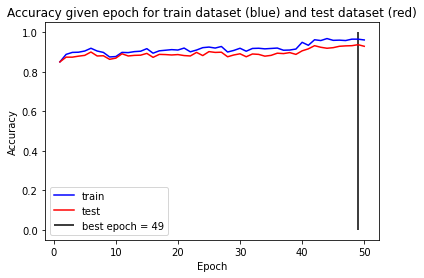

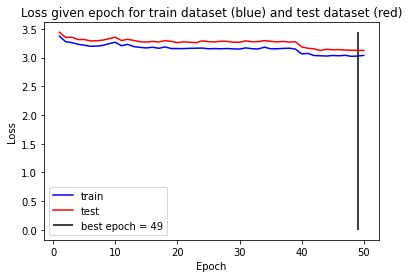

<Figure size 432x288 with 0 Axes>

In [216]:
model = Sub_LeNet5(weight_sharing=True, aux_loss=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_params = sum(p.numel() for p in model.parameters())
print("Number of params : ", num_params)

train_acc, train_loss, test_acc, test_loss = model.fit(train_input, train_target, train_classes, test_input, test_target, test_classes, optimizer, criterion)        